In [171]:
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
import pandas as pd
from tqdm import tqdm

import importlib
import foraging_choice as fc
from foraging_choice import compute_foraging_choice

from aind_behavior_gym.dynamic_foraging.task import (CoupledBlockTask,
                                                     RandomWalkTask,
                                                     UncoupledBlockTask)
from aind_dynamic_foraging_models import generative_model
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_behavior_gym.dynamic_foraging.agent.random_agent import RandomAgent, RandomAgentBiasedIgnore
from aind_dynamic_foraging_models.generative_model.params import ParamsSymbols
from aind_dynamic_foraging_models.generative_model.params.util import get_params_options
from aind_dynamic_foraging_basic_analysis import compute_foraging_efficiency

importlib.reload(fc)
print(dir(fc))


['ForagingSessionData', 'List', 'Tuple', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add_block_transitions_and_stats', 'compute_foraging_choice', 'np', 'pd']


##### Testing Foraging Choice Metric #####

In [172]:

def get_history_from_nwb(nwb_file):
    """Get choice and reward history from nwb file"""

    io = NWBHDF5IO(nwb_file, mode="r")
    nwb = io.read()
    df_trial = nwb.trials.to_dataframe()

    autowater_offered = (df_trial.auto_waterL == 1) | (df_trial.auto_waterR == 1)
    choice_history = df_trial.animal_response.map({0: 0, 1: 1, 2: np.nan}).values
    reward_history = df_trial.rewarded_historyL | df_trial.rewarded_historyR
    p_reward = [
        df_trial.reward_probabilityL.values,
        df_trial.reward_probabilityR.values,
    ]
    random_number = [
        df_trial.reward_random_number_left.values,
        df_trial.reward_random_number_right.values,
    ]

    baiting = False if "without baiting" in nwb.protocol.lower() else True

    return (
        baiting,
        choice_history,
        reward_history,
        p_reward,
        autowater_offered,
        random_number,
    )

In [173]:
working_file = '/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/769887_2024-11-04_09-24-25.nwb'

In [174]:
file_path = working_file
baiting, choice_history, reward_history, p_reward, autowater_offered, random_number = get_history_from_nwb(working_file)

In [175]:
# Print types for all variables

# Print stats for choice_history
print("\nChoice History Stats:")
print(f"Type: {type(choice_history)}")
print(f"Length: {len(choice_history)}")
print(f"Dtype: {choice_history.dtype}")
print(f"Number of unique values: {len(np.unique(choice_history[~np.isnan(choice_history)]))}")
print(f"Missing values: {np.sum(np.isnan(choice_history))}")
print(f"Mean: {np.nanmean(choice_history)}")
print(f"Std: {np.nanstd(choice_history)}")
print(f"Min: {np.nanmin(choice_history)}")
print(f"Max: {np.nanmax(choice_history)}")

# Print stats for reward_history
print("\nReward History Stats:")
print(f"Type: {type(reward_history)}")
print(f"Length: {len(reward_history)}")
print(f"Dtype: {reward_history.dtype}")
print(f"Number of unique values: {reward_history.nunique()}")
print(f"Missing values: {reward_history.isna().sum()}")
print(f"True count: {reward_history.sum()}")
print(f"False count: {(~reward_history).sum()}")

# Print stats for p_reward
print("\nP Reward Stats:")
print(f"Type: {type(p_reward)}")
print("Left Side:")
print(f"Length: {len(p_reward[0])}")
print(f"Dtype: {p_reward[0].dtype}")
print(f"Number of unique values: {len(np.unique(p_reward[0]))}")
print(f"Missing values: {np.sum(np.isnan(p_reward[0]))}")
print(f"Mean: {np.mean(p_reward[0])}")
print(f"Std: {np.std(p_reward[0])}")
print(f"Min: {np.min(p_reward[0])}")
print(f"Max: {np.max(p_reward[0])}")
print("\nRight Side:")
print(f"Length: {len(p_reward[1])}")
print(f"Dtype: {p_reward[1].dtype}")
print(f"Number of unique values: {len(np.unique(p_reward[1]))}")
print(f"Missing values: {np.sum(np.isnan(p_reward[1]))}")
print(f"Mean: {np.mean(p_reward[1])}")
print(f"Std: {np.std(p_reward[1])}")
print(f"Min: {np.min(p_reward[1])}")
print(f"Max: {np.max(p_reward[1])}")

# Print stats for autowater_offered
print("\nAutowater Offered Stats:")
print(f"Type: {type(autowater_offered)}")
print(f"Length: {len(autowater_offered)}")
print(f"Dtype: {autowater_offered.dtype}")
print(f"Number of unique values: {autowater_offered.nunique()}")
print(f"Missing values: {autowater_offered.isna().sum()}")
print(f"True count: {autowater_offered.sum()}")
print(f"False count: {(~autowater_offered).sum()}")



Choice History Stats:
Type: <class 'numpy.ndarray'>
Length: 594
Dtype: float64
Number of unique values: 2
Missing values: 252
Mean: 0.4152046783625731
Std: 0.49275729667698
Min: 0.0
Max: 1.0

Reward History Stats:
Type: <class 'pandas.core.series.Series'>
Length: 594
Dtype: bool
Number of unique values: 2
Missing values: 0
True count: 59
False count: 535

P Reward Stats:
Type: <class 'list'>
Left Side:
Length: 594
Dtype: float64
Number of unique values: 3
Missing values: 0
Mean: 0.2956228956228957
Std: 0.39731552805806597
Min: 0.0
Max: 1.0

Right Side:
Length: 594
Dtype: float64
Number of unique values: 3
Missing values: 0
Mean: 0.5215488215488214
Std: 0.39197371391153407
Min: 0.0
Max: 1.0

Autowater Offered Stats:
Type: <class 'pandas.core.series.Series'>
Length: 594
Dtype: bool
Number of unique values: 2
Missing values: 0
True count: 186
False count: 408


In [176]:
import importlib
importlib.reload(fc)
print(dir(fc))

['ForagingSessionData', 'List', 'Tuple', 'Union', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'add_block_transitions_and_stats', 'compute_foraging_choice', 'np', 'pd']


In [177]:
local_metric, global_metric = compute_foraging_choice(choice_history, 
                                          reward_history, 
                                          p_reward, 
                                          autowater_offered,
                                          global_calc=None)  # Set to None to get both metrics

print(f'global_metric: {global_metric}')
print(f'local_metric: {local_metric}')

global_metric: 0.3106060606060606
local_metric: 0.8237460397692911


##### Testing Custom Task Environments #####

In [178]:
df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv')

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_3916/3477088254.py:1: DtypeWarning: Columns (31,38,40,42,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/foraging_trials_bonsai.csv')


In [179]:
# Checking values 

print("Rows matching STAGE_1:", len(df[df['auto_train_stage'] == 'STAGE_1']))
print("Rows matching Coupled Baiting:", len(df[df['auto_train_curriculum_name'] == 'Coupled Baiting']))
print("Rows matching version 2.3:", len(df[df['auto_train_curriculum_version'] == '2.3']))

df_test = df[
    (df['auto_train_stage'] == 'STAGE_FINAL') &
    (df['auto_train_curriculum_name'] == 'Coupled Baiting') &
    (df['auto_train_curriculum_version'] == '2.2')
]

print("\nTotal rows after modified filtering:", len(df_test))

Rows matching STAGE_1: 105337
Rows matching Coupled Baiting: 149055
Rows matching version 2.3: 697522

Total rows after modified filtering: 29501


In [180]:
df

,trial,animal_response,rewarded_historyL,rewarded_historyR,bait_left,bait_right,base_reward_probability_sum,reward_probabilityL,reward_probabilityR,reward_random_number_left,...,reward_time_in_session,reward_time_in_trial,choice_time_in_session,choice_time_in_trial,earned_reward,extra_reward,subject_id,session_date,reward_delay,minimum_opto_interval
0,0,2.0,False,False,False,False,0.45,0.4,0.05,0.789076,...,NaN,NaN,NaN,NaN,False,False,687553,2023-12-01,NaN,NaN
1,1,2.0,False,False,False,False,0.45,0.4,0.05,0.518192,...,NaN,NaN,NaN,NaN,False,False,687553,2023-12-01,NaN,NaN
2,2,0.0,True,False,True,False,0.45,0.4,0.05,0.367511,...,16.160096,0.487072,16.153088,0.480064,True,False,687553,2023-12-01,NaN,NaN
3,3,0.0,True,False,True,False,0.45,0.4,0.05,0.053372,...,25.333088,0.376064,25.331872,0.374848,True,False,687553,2023-12-01,NaN,NaN
4,4,0.0,False,False,False,False,0.45,0.4,0.05,0.955191,...,NaN,NaN,34.364160,0.157440,False,False,687553,2023-12-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577768,582,1.0,False,False,False,False,0.45,0.4,0.05,0.700221,...,NaN,NaN,5378.042624,0.199680,False,False,724555,2024-07-10,0.0,0.0
2577769,583,2.0,False,False,False,False,0.45,0.4,0.05,0.678467,...,NaN,NaN,NaN,NaN,False,False,724555,2024-07-10,0.0,0.0
2577770,584,1.0,False,False,True,False,0.45,0.4,0.05,0.050451,...,NaN,NaN,5392.707232,0.347424,False,False,724555,2024-07-10,0.0,0.0
2577771,585,1.0,False,False,True,False,0.45,0.4,0.05,0.118763,...,NaN,NaN,5404.919264,0.359232,False,False,724555,2024-07-10,0.0,0.0


In [181]:
# Starting with Coupled Baiting Block Task

stage_vector = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']

# Base off streamlit or bonsai data?

STAGE_1 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 20,
    block_beta = 5,
    p_reward_pairs = [
        [0.8, 0]
    ],
    seed=42
)

STAGE_2 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 200,
    block_min = 10,
    block_max = 40,
    block_beta = 10,
    p_reward_pairs = [
        [0.55, 0.05]
    ],
    seed=42
)

STAGE_3 = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 300,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05]
    ],
    seed=42
)

STAGE_FINAL = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 400,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

GRADUATED = CoupledBlockTask(
    reward_baiting=True, 
    num_trials= 450,
    block_min = 20,
    block_max = 60,
    block_beta = 20,
    p_reward_pairs = [
        [0.4, 0.05],
        [0.25, 0.2],
        [0.1, 0.35],
        [0.3, 0.15]
    ],
    seed=42
)

##### Testing Agent in Task Environments #####

In [182]:
# Test agent on all task environments 

def run_task_env(task, stage_name, n_sims=100, seed_start=42, learning_rates=None):
    """
    Run n simulations for each stage task and get foraging choice values
    
    Params:
    
    task : CoupledBlockTask
        Task environment to run simulations on
    stage_name : str
        Name of the task stage
    n_sims : int, optional
        Number of simulations to run. Defaults to 100
    seed_start : int, optional
        Starting random seed. Defaults to 42
    learning_rates : list or tuple, optional
        Range of rewarded learning rates to test (min, max). If None, uses default rate
    """ 
    results = []

    # If learning rates provided, create evenly spaced samples
    if learning_rates is not None:
        lr_min, lr_max = learning_rates
        learning_rate_values = np.linspace(lr_min, lr_max, n_sims)  # Changed from random sampling
    
    for sim in tqdm(range(n_sims), desc=f'Running {n_sims} simulations'):
        # Create forager for each sim
        forager_collection = ForagerCollection()
        forager = forager_collection.get_preset_forager('Hattori2019', seed=seed_start+sim)
        
        # Set parameters
        params = {
            'softmax_inverse_temperature': 5,
            'biasL': 0
        }

        # Add learning rate if provided - use indexed value instead of random
        if learning_rates is not None:
            lr = learning_rate_values[sim]  # Changed from random sampling
            params['learn_rate_rew'] = lr

        # Update parameters using model_copy
        forager.params = forager.params.model_copy(update=params)
        
        # Set new seed
        task.seed = seed_start + sim
        forager.perform(task)

        # Calculate metrics
        foraging_eff, eff_random_seed = compute_foraging_efficiency(
            baited=task.reward_baiting,
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            random_number=task.random_numbers.T,
        )
        
        foraging_choice_local, foraging_choice_global = compute_foraging_choice(
            choice_history=forager.get_choice_history(),
            reward_history=forager.get_reward_history(),
            p_reward=forager.get_p_reward(),
            global_calc=None
        )
        
        results.append({
            'stage': stage_name,
            'simulation': sim,
            'foraging_efficiency': foraging_eff,
            'foraging_efficiency_random_seed': eff_random_seed,
            'foraging_choice_local': foraging_choice_local,
            'foraging_choice_global': foraging_choice_global,
            'random_seed': seed_start + sim,
            'num_trials': task.num_trials,
            'block_min': task.block_min,
            'block_max': task.block_max,
            'block_beta': task.block_beta,
            'learning_rate': lr if learning_rates is not None else None
        })
    
    return pd.DataFrame(results)

In [183]:
# Create dictionary of task environments

tasks = {
    'STAGE_1': STAGE_1,
    'STAGE_2': STAGE_2,
    'STAGE_3': STAGE_3,
    'STAGE_FINAL': STAGE_FINAL,
    'GRADUATED': GRADUATED
}

# Set function args
n_sims = 10000
seed_start = 42

# Run simulations
all_results = []

for stage_name, task in tasks.items():
    print(f'\nRunning {stage_name} task...')
    results_df = run_task_env(task, stage_name, n_sims=n_sims, learning_rates=[0, 4])
    all_results.append(results_df)

combined_results = pd.concat(all_results, ignore_index=True)


Running STAGE_1 task...


Running 10000 simulations: 100%|██████████| 10000/10000 [01:16<00:00, 131.33it/s]



Running STAGE_2 task...


Running 10000 simulations:  86%|████████▌ | 8603/10000 [01:08<00:10, 127.70it/s]/Users/nickkeesey/miniforge3/envs/Main/lib/python3.12/site-packages/aind_dynamic_foraging_models/generative_model/act_functions.py:232: RuntimeWarning: invalid value encountered in divide
  return np.exp(x) / np.sum(np.exp(x))
Running 10000 simulations: 100%|██████████| 10000/10000 [01:19<00:00, 126.22it/s]



Running STAGE_3 task...


Running 10000 simulations: 100%|██████████| 10000/10000 [01:52<00:00, 89.05it/s]



Running STAGE_FINAL task...


Running 10000 simulations: 100%|██████████| 10000/10000 [02:27<00:00, 67.69it/s]



Running GRADUATED task...


Running 10000 simulations: 100%|██████████| 10000/10000 [02:53<00:00, 57.52it/s]


In [184]:
combined_results.sort_values(by='learning_rate', ascending=True)

,stage,simulation,foraging_efficiency,foraging_efficiency_random_seed,foraging_choice_local,foraging_choice_global,random_seed,num_trials,block_min,block_max,block_beta,learning_rate
0,STAGE_1,0,0.600000,0.578313,-0.012049,-0.030000,42,200,10,20,5,0.0
30000,STAGE_FINAL,0,0.878266,0.862275,0.058091,0.025714,42,400,20,60,20,0.0
40000,GRADUATED,0,0.862116,0.845745,0.066694,0.012698,42,450,20,60,20,0.0
10000,STAGE_2,0,0.671276,0.684685,-0.110529,-0.090000,42,200,10,40,10,0.0
20000,STAGE_3,0,0.833085,0.785185,0.052246,0.046667,42,300,20,60,20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39999,STAGE_FINAL,9999,0.563924,0.598684,-0.172997,-0.207143,10041,400,20,60,20,4.0
19999,STAGE_2,9999,0.379801,0.380531,-0.529150,-0.530000,10041,200,10,40,10,4.0
9999,STAGE_1,9999,0.243750,0.230769,-0.700958,-0.710000,10041,200,10,20,5,4.0
29999,STAGE_3,9999,0.455839,0.467742,-0.456453,-0.540000,10041,300,20,60,20,4.0


/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_3916/3632180375.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  local_pivot = pd.pivot_table(
/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_3916/3632180375.py:17: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  global_pivot = pd.pivot_table(


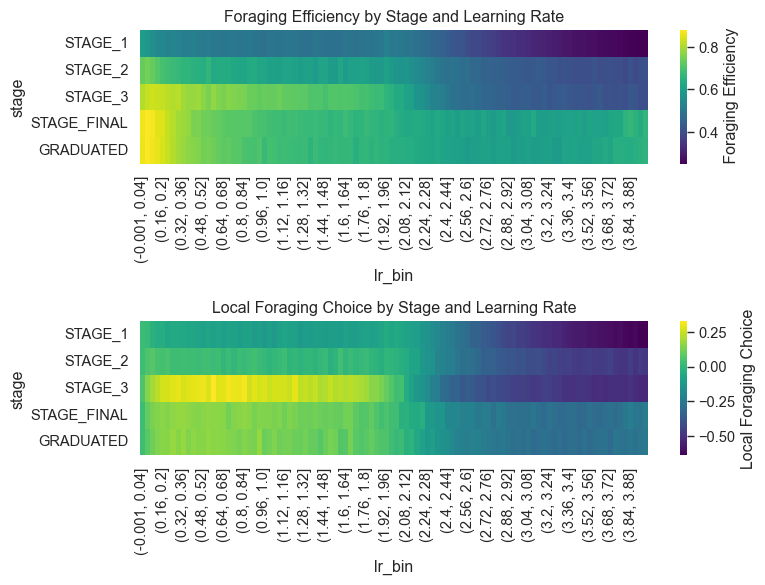

In [185]:
# Heatmap showing average metrics for learning rate bins by stage

combined_results['lr_bin'] = pd.qcut(combined_results['learning_rate'], q=100)

# Define stage order
stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']

# Create pivot tables for both metrics
local_pivot = pd.pivot_table(
    combined_results, 
    values='foraging_choice_local',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
).reindex(stage_order)

global_pivot = pd.pivot_table(
    combined_results, 
    values='foraging_efficiency',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
).reindex(stage_order)

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.heatmap(local_pivot, ax=ax2, cmap='viridis', 
            annot=False, fmt='.2f', cbar_kws={'label': 'Local Foraging Choice'})
ax2.set_title('Local Foraging Choice by Stage and Learning Rate')

sns.heatmap(global_pivot, ax=ax1, cmap='viridis',
            annot=False, fmt='.2f', cbar_kws={'label': ' Foraging Efficiency'})
ax1.set_title('Foraging Efficiency by Stage and Learning Rate')

plt.tight_layout()
plt.show()

/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_3916/1119436544.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_bin = combined_results.groupby(['stage', 'lr_bin']).agg({


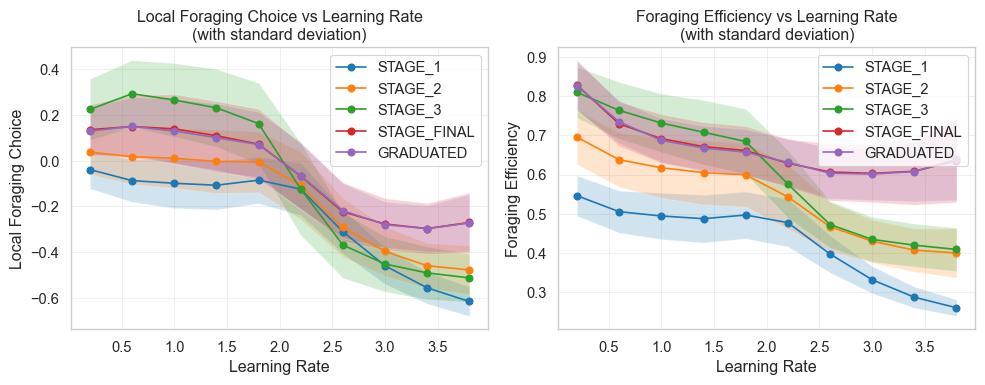

In [195]:
# 1. Line plot with error bars
plt.figure(figsize=(10, 4))

# Create bins for learning rate to smooth the plot
combined_results['lr_bin'] = pd.qcut(combined_results['learning_rate'], q=10)
mean_by_bin = combined_results.groupby(['stage', 'lr_bin']).agg({
    'learning_rate': 'mean',
    'foraging_choice_local': ['mean', 'std'],
    'foraging_efficiency': ['mean', 'std']
}).reset_index()

# Plot for local metric
plt.subplot(1, 2, 1)
for stage in tasks.keys():
    stage_data = mean_by_bin[mean_by_bin['stage'] == stage]
    plt.fill_between(stage_data[('learning_rate', 'mean')],
                    stage_data[('foraging_choice_local', 'mean')] - stage_data[('foraging_choice_local', 'std')],
                    stage_data[('foraging_choice_local', 'mean')] + stage_data[('foraging_choice_local', 'std')],
                    alpha=0.2)
    plt.plot(stage_data[('learning_rate', 'mean')],
             stage_data[('foraging_choice_local', 'mean')],
             label=stage, marker='o')

plt.xlabel('Learning Rate')
plt.ylabel('Local Foraging Choice')
plt.title('Local Foraging Choice vs Learning Rate\n(with standard deviation)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot for foraging efficiency
plt.subplot(1, 2, 2)
for stage in tasks.keys():
    stage_data = mean_by_bin[mean_by_bin['stage'] == stage]
    plt.fill_between(stage_data[('learning_rate', 'mean')],
                    stage_data[('foraging_efficiency', 'mean')] - stage_data[('foraging_efficiency', 'std')],
                    stage_data[('foraging_efficiency', 'mean')] + stage_data[('foraging_efficiency', 'std')],
                    alpha=0.2)
    plt.plot(stage_data[('learning_rate', 'mean')],
             stage_data[('foraging_efficiency', 'mean')],
             label=stage, marker='o')

plt.xlabel('Learning Rate')
plt.ylabel('Foraging Efficiency')
plt.title('Foraging Efficiency vs Learning Rate\n(with standard deviation)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##### Testing Optimizing Parameters by Learning Rate #####

In [205]:
def optimize_stage_params(task, stage_name, n_sims=10, seed_start=42):
    """
    Optimize parameters for each stage task
    """
    
    # Initialize parameter search range
    learn_rates_unrew = np.linspace(0, 1, 30)
    forget_rates = np.linspace(0, 1, 30)
    temps = np.logspace(-1, 1, 30)

    optimals = {
        'efficiency': {
            'efficiency': 0,
            'local_choice': 0,
            'params': None
        },
        'local_choice': {
            'efficiency': 0, 
            'local_choice': 0,
            'params': None
        }
    }

    # Grid search over parameter space
    total_combinations = len(learn_rates_unrew) * len(forget_rates) * len(temps)
    with tqdm(total=total_combinations, desc=f'Optimizing {stage_name} parameters') as pbar:
        for lr_unrew in learn_rates_unrew:
            for forget_rate in forget_rates:
                for temp in temps:
                    results = []

                    # Run n sims with parameter selection
                    for sim in range(n_sims):
                        forager_collection = ForagerCollection()
                        forager = forager_collection.get_preset_forager('Hattori2019', seed=seed_start+sim)
                        params = {
                            'learn_rate_unrew': lr_unrew,
                            'forget_rate_unchosen': forget_rate,
                            'softmax_inverse_temperature': temp,
                            'biasL': 0
                        }

                        forager.params = forager.params.model_copy(update=params)

                        # Run simulation
                        task.seed = seed_start + sim
                        forager.perform(task)

                        # get metrics
                        eff, _ = compute_foraging_efficiency(
                            baited=task.reward_baiting,
                            choice_history=forager.get_choice_history(),
                            reward_history=forager.get_reward_history(),
                            p_reward=forager.get_p_reward(),
                            random_number=task.random_numbers.T,
                        )

                        local, _ = compute_foraging_choice(
                            choice_history=forager.get_choice_history(),
                            reward_history=forager.get_reward_history(),
                            p_reward=forager.get_p_reward(),
                            global_calc=None
                        )

                        results.append({
                            'efficiency': eff,
                            'local_choice': local,
                        })

                        # average metrics across sims
                        avg_metrics = pd.DataFrame(results).mean()

                        # Update optimals for efficiency
                        if avg_metrics['efficiency'] > optimals['efficiency']['efficiency']:
                            optimals['efficiency'] = {
                                'efficiency': avg_metrics['efficiency'],
                                'local_choice': avg_metrics['local_choice'],
                                'params': {
                                    'learn_rate_unrew': lr_unrew,
                                    'forget_rate_unchosen': forget_rate,
                                    'softmax_inverse_temperature': temp
                                }
                            }

                        # Update optimals for local choice
                        if avg_metrics['local_choice'] > optimals['local_choice']['local_choice']:
                            optimals['local_choice'] = {
                                'efficiency': avg_metrics['efficiency'],
                                'local_choice': avg_metrics['local_choice'],
                                'params': {
                                    'learn_rate_unrew': lr_unrew,
                                    'forget_rate_unchosen': forget_rate,
                                    'softmax_inverse_temperature': temp
                                }
                            }

                    pbar.update(1)

    return optimals

In [206]:
# Optimize parameters for each stage
optimized_params = {}
for stage_name, task in tasks.items():
    print(f"\nOptimizing parameters for {stage_name}...")
    optimized_params[stage_name] = optimize_stage_params(task, stage_name)
    
    print(f"\nBest parameters for {stage_name} by efficiency:")
    print(f"Parameters: {optimized_params[stage_name]['efficiency']['params']}")
    print(f"Efficiency: {optimized_params[stage_name]['efficiency']['efficiency']:.3f}")
    print(f"Local Choice: {optimized_params[stage_name]['efficiency']['local_choice']:.3f}")

    print(f"\nBest parameters for {stage_name} by local choice:")
    print(f"Parameters: {optimized_params[stage_name]['local_choice']['params']}")
    print(f"Efficiency: {optimized_params[stage_name]['local_choice']['efficiency']:.3f}")
    print(f"Local Choice: {optimized_params[stage_name]['local_choice']['local_choice']:.3f}")


Optimizing parameters for STAGE_1...


Optimizing STAGE_1 parameters: 100%|██████████| 27000/27000 [36:18<00:00, 12.40it/s]  



Best parameters for STAGE_1 by efficiency:
Parameters: {'learn_rate_unrew': 0.9655172413793103, 'forget_rate_unchosen': 0.9655172413793103, 'softmax_inverse_temperature': 6.2101694189156165}
Efficiency: 0.969
Local Choice: 0.734

Best parameters for STAGE_1 by local choice:
Parameters: {'learn_rate_unrew': 0.896551724137931, 'forget_rate_unchosen': 0.13793103448275862, 'softmax_inverse_temperature': 7.27895384398315}
Efficiency: 0.963
Local Choice: 0.779

Optimizing parameters for STAGE_2...


Optimizing STAGE_2 parameters: 100%|██████████| 27000/27000 [37:54<00:00, 11.87it/s]  



Best parameters for STAGE_2 by efficiency:
Parameters: {'learn_rate_unrew': 0.8275862068965517, 'forget_rate_unchosen': 0.24137931034482757, 'softmax_inverse_temperature': 6.2101694189156165}
Efficiency: 1.060
Local Choice: 0.527

Best parameters for STAGE_2 by local choice:
Parameters: {'learn_rate_unrew': 0.5862068965517241, 'forget_rate_unchosen': 0.9310344827586207, 'softmax_inverse_temperature': 10.0}
Efficiency: 0.874
Local Choice: 0.709

Optimizing parameters for STAGE_3...


Optimizing STAGE_3 parameters: 100%|██████████| 27000/27000 [52:41<00:00,  8.54it/s] 



Best parameters for STAGE_3 by efficiency:
Parameters: {'learn_rate_unrew': 0.6896551724137931, 'forget_rate_unchosen': 0.034482758620689655, 'softmax_inverse_temperature': 8.531678524172806}
Efficiency: 1.140
Local Choice: 0.550

Best parameters for STAGE_3 by local choice:
Parameters: {'learn_rate_unrew': 0.3793103448275862, 'forget_rate_unchosen': 0.896551724137931, 'softmax_inverse_temperature': 8.531678524172806}
Efficiency: 1.069
Local Choice: 0.778

Optimizing parameters for STAGE_FINAL...


Optimizing STAGE_FINAL parameters: 100%|██████████| 27000/27000 [1:07:12<00:00,  6.69it/s]



Best parameters for STAGE_FINAL by efficiency:
Parameters: {'learn_rate_unrew': 0.7586206896551724, 'forget_rate_unchosen': 0.3793103448275862, 'softmax_inverse_temperature': 0.18873918221350972}
Efficiency: 1.120
Local Choice: 0.032

Best parameters for STAGE_FINAL by local choice:
Parameters: {'learn_rate_unrew': 0.4482758620689655, 'forget_rate_unchosen': 0.41379310344827586, 'softmax_inverse_temperature': 8.531678524172806}
Efficiency: 0.913
Local Choice: 0.606

Optimizing parameters for GRADUATED...


Optimizing GRADUATED parameters:  11%|█         | 3028/27000 [08:31<1:06:27,  6.01it/s]

In [196]:
# Create DataFrame from optimized parameters
rows = []
for stage_name, results in optimized_params.items():
    # Add row for efficiency-optimized parameters
    efficiency_row = {
        'stage': stage_name,
        'optimized_for': 'efficiency',
        'efficiency_score': results['efficiency']['efficiency'],
        'local_choice_score': results['efficiency']['local_choice'],
        **results['efficiency']['params']  # Unpack the parameter dictionary
    }
    rows.append(efficiency_row)
    
    # Add row for local choice-optimized parameters
    local_choice_row = {
        'stage': stage_name,
        'optimized_for': 'local_choice',
        'efficiency_score': results['local_choice']['efficiency'],
        'local_choice_score': results['local_choice']['local_choice'],
        **results['local_choice']['params']  # Unpack the parameter dictionary
    }
    rows.append(local_choice_row)

# Create DataFrame
optimized_params_df = pd.DataFrame(rows)

# Optional: Set better column order
column_order = [
    'stage', 
    'optimized_for',
    'learn_rate_unrew',
    'forget_rate_unchosen',
    'softmax_inverse_temperature',
    'efficiency_score',
    'local_choice_score'
]
optimized_params_df = optimized_params_df[column_order]

optimized_params_df

,stage,optimized_for,learn_rate_unrew,forget_rate_unchosen,softmax_inverse_temperature,efficiency_score,local_choice_score
0,STAGE_1,efficiency,0.947368,0.368421,10.000000,0.950000,0.530744
1,STAGE_1,local_choice,0.842105,0.789474,10.000000,0.875000,0.686898
2,STAGE_2,efficiency,0.684211,0.631579,6.158482,1.033412,0.618676
3,STAGE_2,local_choice,0.473684,0.894737,7.847600,0.883258,0.705491
4,STAGE_3,efficiency,0.473684,0.157895,6.158482,1.053145,0.258871
5,STAGE_3,local_choice,0.315789,0.315789,10.000000,0.958834,0.736270
6,STAGE_FINAL,efficiency,0.894737,0.263158,0.162378,1.073762,0.056325
7,STAGE_FINAL,local_choice,0.263158,1.000000,7.847600,0.853800,0.590745
8,GRADUATED,efficiency,0.368421,0.684211,0.127427,1.070063,-0.054148
9,GRADUATED,local_choice,0.421053,0.263158,10.000000,0.912209,0.574787


In [197]:
optimized_params_df.to_csv('/Users/nickkeesey/Desktop/learning-dynamics-behavior/data/optimized_foraging_params.csv')

In [191]:
optimized_params_df

""


In [198]:
# Test agent on all task environments 

def optimized_run_task_env(task, stage_name, n_sims=100, seed_start=42, learning_rates=None):
    """
    Run n simulations for each stage task and get foraging choice values
    
    Params:
    
    task : CoupledBlockTask
        Task environment to run simulations on
    stage_name : str
        Name of the task stage
    n_sims : int, optional
        Number of simulations to run. Defaults to 100
    seed_start : int, optional
        Starting random seed. Defaults to 42
    learning_rates : list or tuple, optional
        Range of rewarded learning rates to test (min, max). If None, uses default rate
    """ 
    results = []

    # Get optimized parameters for this stage
    stage_params = optimized_params_df[optimized_params_df['stage'] == stage_name]
    efficiency_params = stage_params[stage_params['optimized_for'] == 'efficiency'].iloc[0]
    local_choice_params = stage_params[stage_params['optimized_for'] == 'local_choice'].iloc[0]
    
    # If learning rates provided, create evenly spaced samples
    if learning_rates is not None:
        lr_min, lr_max = learning_rates
        learning_rate_values = np.linspace(lr_min, lr_max, n_sims)
    
    # Run simulations for both parameter sets
    for param_type, params_set in [('efficiency', efficiency_params), ('local_choice', local_choice_params)]:
        for sim in tqdm(range(n_sims), desc=f'Running {n_sims} simulations'):
            # Create forager for each sim
            forager_collection = ForagerCollection()
            forager = forager_collection.get_preset_forager('Hattori2019', seed=seed_start+sim)
            
            # Set parameters using optimized values
            params = {
                'softmax_inverse_temperature': params_set['softmax_inverse_temperature'],
                'learn_rate_unrew': params_set['learn_rate_unrew'],
                'forget_rate_unchosen': params_set['forget_rate_unchosen'],
                'biasL': 0
            }

            # Add learning rate if provided - use indexed value instead of random
            if learning_rates is not None:
                lr = learning_rate_values[sim]
                params['learn_rate_rew'] = lr

            # Update parameters using model_copy
            forager.params = forager.params.model_copy(update=params)
            
            # Set new seed
            task.seed = seed_start + sim
            forager.perform(task)

            # Calculate metrics
            foraging_eff, eff_random_seed = compute_foraging_efficiency(
                baited=task.reward_baiting,
                choice_history=forager.get_choice_history(),
                reward_history=forager.get_reward_history(),
                p_reward=forager.get_p_reward(),
                random_number=task.random_numbers.T,
            )
            
            foraging_choice_local, foraging_choice_global = compute_foraging_choice(
                choice_history=forager.get_choice_history(),
                reward_history=forager.get_reward_history(),
                p_reward=forager.get_p_reward(),
                global_calc=None
            )
            
            results.append({
                'stage': stage_name,
                'optimization_type': param_type,
                'simulation': sim,
                'foraging_efficiency': foraging_eff,
                'foraging_efficiency_random_seed': eff_random_seed,
                'foraging_choice_local': foraging_choice_local,
                'foraging_choice_global': foraging_choice_global,
                'random_seed': seed_start + sim,
                'num_trials': task.num_trials,
                'block_min': task.block_min,
                'block_max': task.block_max,
                'block_beta': task.block_beta,
                'learning_rate': lr if learning_rates is not None else None
            })
    
    return pd.DataFrame(results)

In [199]:
# Create dictionary of task environments

tasks = {
    'STAGE_1': STAGE_1,
    'STAGE_2': STAGE_2,
    'STAGE_3': STAGE_3,
    'STAGE_FINAL': STAGE_FINAL,
    'GRADUATED': GRADUATED
}

# Set function args
n_sims = 1000
seed_start = 42

# Run simulations
all_results = []

for stage_name, task in tasks.items():
    print(f'\nRunning {stage_name} task...')
    results_df = optimized_run_task_env(task, stage_name, n_sims=n_sims, learning_rates=[0, 4])
    all_results.append(results_df)

optimized_results = pd.concat(all_results, ignore_index=True)


Running STAGE_1 task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:07<00:00, 126.94it/s]



Running STAGE_2 task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:08<00:00, 124.37it/s]



Running STAGE_3 task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:11<00:00, 88.17it/s]



Running STAGE_FINAL task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:14<00:00, 67.21it/s]



Running GRADUATED task...


Running 1000 simulations: 100%|██████████| 1000/1000 [00:16<00:00, 60.41it/s]


In [200]:
# Add this function before creating the tasks
def calculate_reward_contrast(p_reward_pairs):
    """
    Calculate the contrast between reward probabilities in each pair
    Returns a list of contrasts for each pair with 4 significant figures
    """
    return [round(abs(pair[0] - pair[1]), 4) for pair in p_reward_pairs]

# After creating all the STAGE tasks, create a dictionary and convert to DataFrame  
task_info = {
    'STAGE_1': {
        'num_pairs': len(STAGE_1.p_reward_pairs),
        'mean_contrasts': np.mean(calculate_reward_contrast(STAGE_1.p_reward_pairs)),
        'std_contrasts': '{:.2e}'.format(np.std(calculate_reward_contrast(STAGE_1.p_reward_pairs)))
    },
    'STAGE_2': {
        'num_pairs': len(STAGE_2.p_reward_pairs),
        'mean_contrasts': np.mean(calculate_reward_contrast(STAGE_2.p_reward_pairs)),
        'std_contrasts': '{:.2e}'.format(np.std(calculate_reward_contrast(STAGE_2.p_reward_pairs)))
    },
    'STAGE_3': {
        'num_pairs': len(STAGE_3.p_reward_pairs),
        'mean_contrasts': np.mean(calculate_reward_contrast(STAGE_3.p_reward_pairs)),
        'std_contrasts': '{:.2e}'.format(np.std(calculate_reward_contrast(STAGE_3.p_reward_pairs)))
    },
    'STAGE_FINAL': {
        'num_pairs': len(STAGE_FINAL.p_reward_pairs),
        'mean_contrasts': np.mean(calculate_reward_contrast(STAGE_FINAL.p_reward_pairs)),
        'std_contrasts': '{:.2e}'.format(np.std(calculate_reward_contrast(STAGE_FINAL.p_reward_pairs)))
    },
    'GRADUATED': {
        'num_pairs': len(GRADUATED.p_reward_pairs),
        'mean_contrasts': np.mean(calculate_reward_contrast(GRADUATED.p_reward_pairs)),
        'std_contrasts': '{:.2e}'.format(np.std(calculate_reward_contrast(GRADUATED.p_reward_pairs)))
    }
}

df = pd.DataFrame.from_dict(task_info, orient='index')
df = df.reset_index().rename(columns={'index': 'stage'})

optimized_results = optimized_results.merge(
    df,
    left_on='stage',
    right_on='stage',
    how='left'
)

optimized_results

,stage,optimization_type,simulation,foraging_efficiency,foraging_efficiency_random_seed,foraging_choice_local,foraging_choice_global,random_seed,num_trials,block_min,block_max,block_beta,learning_rate,num_pairs,mean_contrasts,std_contrasts
0,STAGE_1,efficiency,0,0.662500,0.654321,0.111566,0.120000,42,200,10,20,5,0.000000,1,0.8,0.00e+00
1,STAGE_1,efficiency,1,0.625000,0.636943,-0.014534,0.040000,43,200,10,20,5,0.004004,1,0.8,0.00e+00
2,STAGE_1,efficiency,2,0.618750,0.582353,0.080976,0.080000,44,200,10,20,5,0.008008,1,0.8,0.00e+00
3,STAGE_1,efficiency,3,0.681250,0.685535,0.205571,0.210000,45,200,10,20,5,0.012012,1,0.8,0.00e+00
4,STAGE_1,efficiency,4,0.606250,0.617834,0.118117,0.100000,46,200,10,20,5,0.016016,1,0.8,0.00e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,GRADUATED,local_choice,995,0.637102,0.624339,-0.254984,-0.240000,1037,450,20,60,20,3.983984,4,0.2,1.12e-01
9996,GRADUATED,local_choice,996,0.664771,0.701149,-0.023990,-0.074286,1038,450,20,60,20,3.987988,4,0.2,1.12e-01
9997,GRADUATED,local_choice,997,0.623563,0.715190,0.029402,-0.010794,1039,450,20,60,20,3.991992,4,0.2,1.12e-01
9998,GRADUATED,local_choice,998,0.619009,0.642045,-0.165139,-0.163175,1040,450,20,60,20,3.995996,4,0.2,1.12e-01


/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_3916/38149368.py:10: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  optim_efficiency_pivot = pd.pivot_table(
/var/folders/mr/k7gx9xps333170k7zsggl4tw0000gn/T/ipykernel_3916/38149368.py:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  optim_local_pivot = pd.pivot_table(


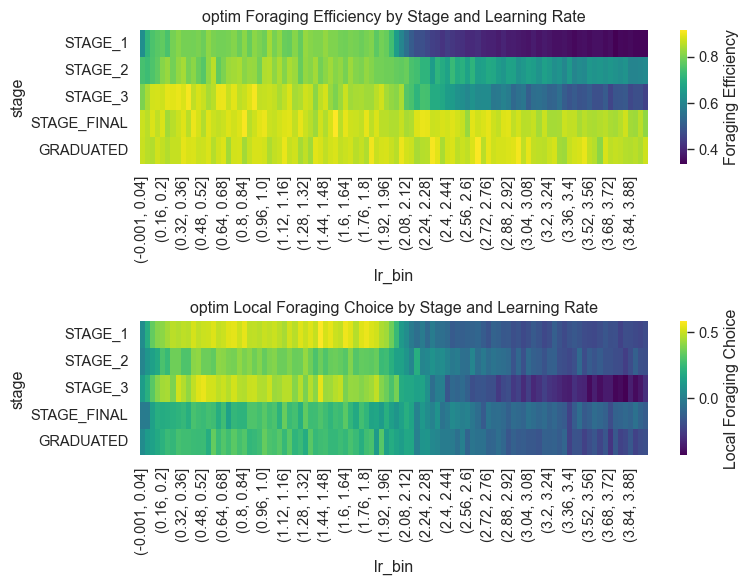

In [201]:
optimized_results['lr_bin'] = pd.qcut(optimized_results['learning_rate'], q=100)

# Seperate optimized types
optim_efficiency = optimized_results[optimized_results['optimization_type'] == 'efficiency']
optim_local_choice = optimized_results[optimized_results['optimization_type'] == 'local_choice']

stage_order = ['STAGE_1', 'STAGE_2', 'STAGE_3', 'STAGE_FINAL', 'GRADUATED']

# Create pivot tables for both metrics
optim_efficiency_pivot = pd.pivot_table(
    optim_efficiency, 
    values='foraging_efficiency',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
).reindex(stage_order)

optim_local_pivot = pd.pivot_table(
    optim_local_choice, 
    values='foraging_choice_local',
    index='stage',
    columns='lr_bin',
    aggfunc='mean'
).reindex(stage_order)

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sns.heatmap(optim_efficiency_pivot, ax=ax1, cmap='viridis', 
            annot=False, fmt='.2f', cbar_kws={'label': 'Foraging Efficiency'})
ax1.set_title('optim Foraging Efficiency by Stage and Learning Rate')

sns.heatmap(optim_local_pivot, ax=ax2, cmap='viridis',
            annot=False, fmt='.2f', cbar_kws={'label': 'Local Foraging Choice'})
ax2.set_title('optim Local Foraging Choice by Stage and Learning Rate')

plt.tight_layout()
plt.show()

In [202]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import scipy.sparse
from sklearn.decomposition import PCA


numerical_features = ['num_pairs', 'mean_contrasts', 'std_contrasts']
categorical_features = ['stage']

# Create preprocessor 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# Fit and transform data
X = preprocessor.fit_transform(optimized_results[numerical_features + categorical_features])

# Convert sparse array to dense
if scipy.sparse.issparse(X):
    X = X.toarray()
 
pca = PCA()
X_pca = pca.fit_transform(X)


# Perform PCA
onehot_features = (preprocessor
                   .named_transformers_['cat']
                   .get_feature_names_out(categorical_features))

feature_names = numerical_features + list(onehot_features)

print("Explained variance ratio: ", pca.explained_variance_ratio_)

# Create df with PCA features
# Create DataFrame with PCA results
pca_df = pd.DataFrame(
    X_pca, 
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]
)

# If you want to see component loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])],
    index=feature_names
)

Explained variance ratio:  [7.78870707e-01 1.39475472e-01 5.49450549e-02 2.67087656e-02
 2.17906692e-15 0.00000000e+00 0.00000000e+00]


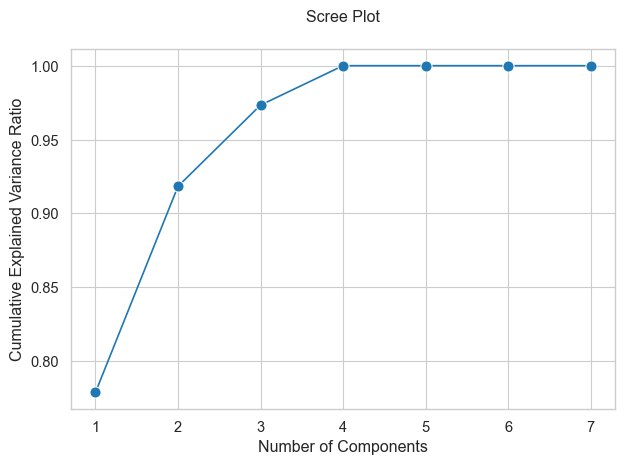

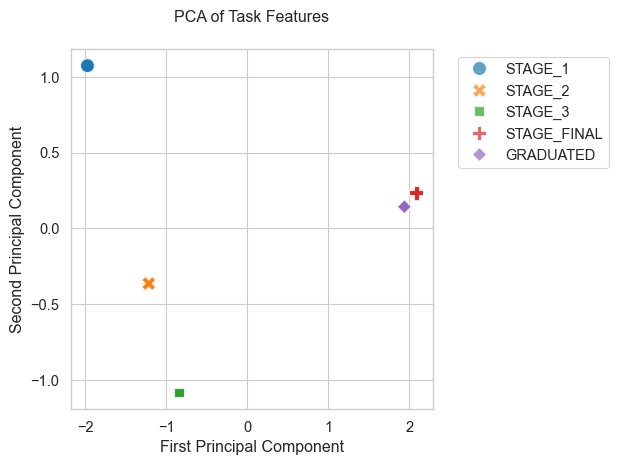

In [204]:
# Scree plot
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1),
            y=np.cumsum(pca.explained_variance_ratio_),
            marker='o', markersize=8)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot', pad=20)
plt.tight_layout()
plt.show()

# Biplot of first two components
sns.scatterplot(data=optimized_results,
                x=X_pca[:, 0], 
                y=X_pca[:, 1],
                hue='stage',
                style='stage',
                s=100,
                alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component') 
plt.title('PCA of Task Features', pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()